In [1]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input, GlobalAveragePooling1D
from keras.layers import Flatten, Dot
from keras.layers.embeddings import Embedding
from keras.models import Model
from umap import UMAP
from sklearn.neighbors import NearestNeighbors
from tokens_and_glov_embs import get_docs
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/home/j/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/j/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/j/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/j/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py

# Process and Visualize Embeddings

### Load GloVe Embedding Matrix and Tokenizer

In [2]:
embedding_matrix = np.load('../preprocessing/glov_emb_matrix.npy')
print('Embedding Matrix:', embedding_matrix.shape)

with open('../preprocessing/tokenizer.pkl', 'rb') as f:
    t = pickle.load(f)

Embedding Matrix: (578207, 100)


### GloVe Embedding Model with 1D Global Average Pooling

In [3]:
vocab_size = 578207
input_length = 10000

# sole glov model
input_tens = Input(shape=(input_length,), name='input_1')
x = Embedding(
    vocab_size, 
    100, 
    input_length=input_length, 
    weights=[embedding_matrix],
    trainable=False
)(input_tens)
#x = Flatten()(x)
x = GlobalAveragePooling1D()(x)

model = Model(inputs=input_tens, outputs=x)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10000, 100)        57820700  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
Total params: 57,820,700
Trainable params: 0
Non-trainable params: 57,820,700
_________________________________________________________________


### Predict Embeddings for all Works

In [5]:
embeddings = np.asarray(()) 
for d in range(0, 30000, 100):
    padded_docs = get_docs('../../scrape_gutenberg/works/', t, d, d+100)
    sub_embs = model.predict(padded_docs, verbose=1)
    if embeddings.size == 0:
        embeddings = sub_embs
    else:
        embeddings = np.vstack((embeddings, sub_embs))
    
    print('Embeddings:', embeddings.shape)

100/100 [==============================] - 0s 4ms/step
Embeddings: (100, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (200, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (300, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (400, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (500, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (600, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (700, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (800, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (900, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (1000, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (1100, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (1200, 100)
100/100 [==============================] - 0s 4ms/step
Embedd

100/100 [==============================] - 0s 4ms/step
Embeddings: (10500, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (10600, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (10700, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (10800, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (10900, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (11000, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (11100, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (11200, 100)
100/100 [==============================] - 0s 4ms/step
Embeddings: (11300, 100)
100/100 [==============================] - 0s 3ms/step
Embeddings: (11400, 100)
100/100 [==============================] - 0s 3ms/step
Embeddings: (11500, 100)
100/100 [==============================] - 0s 3ms/step
Embeddings: (11600, 100)
100/100 [==============================]

### UMAP Embeddings for Visualization

In [6]:
#embeddings = np.load('10000_embeddings.npy')
np.save('30000_embeddings.npy', embeddings)

In [7]:
umap = UMAP(n_neighbors=20, metric='cosine')
vis_embeddings = umap.fit_transform(embeddings)
print('Vis Embeddings:', vis_embeddings.shape)

Vis Embeddings: (30000, 2)


In [9]:
v2_author_df = pd.read_csv('../preprocessing/v2_author_df.csv')
v2_author_df = v2_author_df[:30000]
v2_author_df['umap_1'] = vis_embeddings[:, 0]
v2_author_df['umap_2'] = vis_embeddings[:, 1]
v2_author_df.head(10)

doc_id                       author  \
0       0               Beatrix_Potter   
1       1                      Stewart   
2       2       Herbert_George_Jenkins   
3       3              Robina_F._Hardy   
4       4                  Mme._Campan   
5       5                      Unknown   
6       6                      Various   
7       7  Friedrich_Wilhelm_Nietzsche   
8       8          Mary_Finley_Leonard   
9       9                      Various   

                                                work     umap_1     umap_2  
0                    Cecily_Parsley's_Nursery_Rhymes   1.191924   8.660218  
1  The_Camp_Fire_Girls_on_the_March;_Or,_Bessie_K...   7.390335  -4.762022  
2  Bindle:_Some_Chapters_in_the_Life_of_Joseph_Bi...   5.250948  -5.613513  
3                                The_Good_Ship_Rover   1.120215   7.615215  
4  Memoirs_of_the_Court_of_Marie_Antoinette,_Quee...  21.447735  -1.195763  
5  Da_importancia_da_Historia_Universal_Philosoph...   0.830126  16.901146  
6  Blackwood's_Edinburgh_Magazine,_Vol_58,_No._35...   3.954411  -2.215178  
7                                    We_Philologists   3.855316   0.161033  
8   The_Spectacle_Man:_A_Story_of_the_Missing_Bridge  22.120125  -0.684609  
9  Poet-Lore:_A_Quarterly_Magazine_of_Letters._Ap...  21.023094  -1.544172

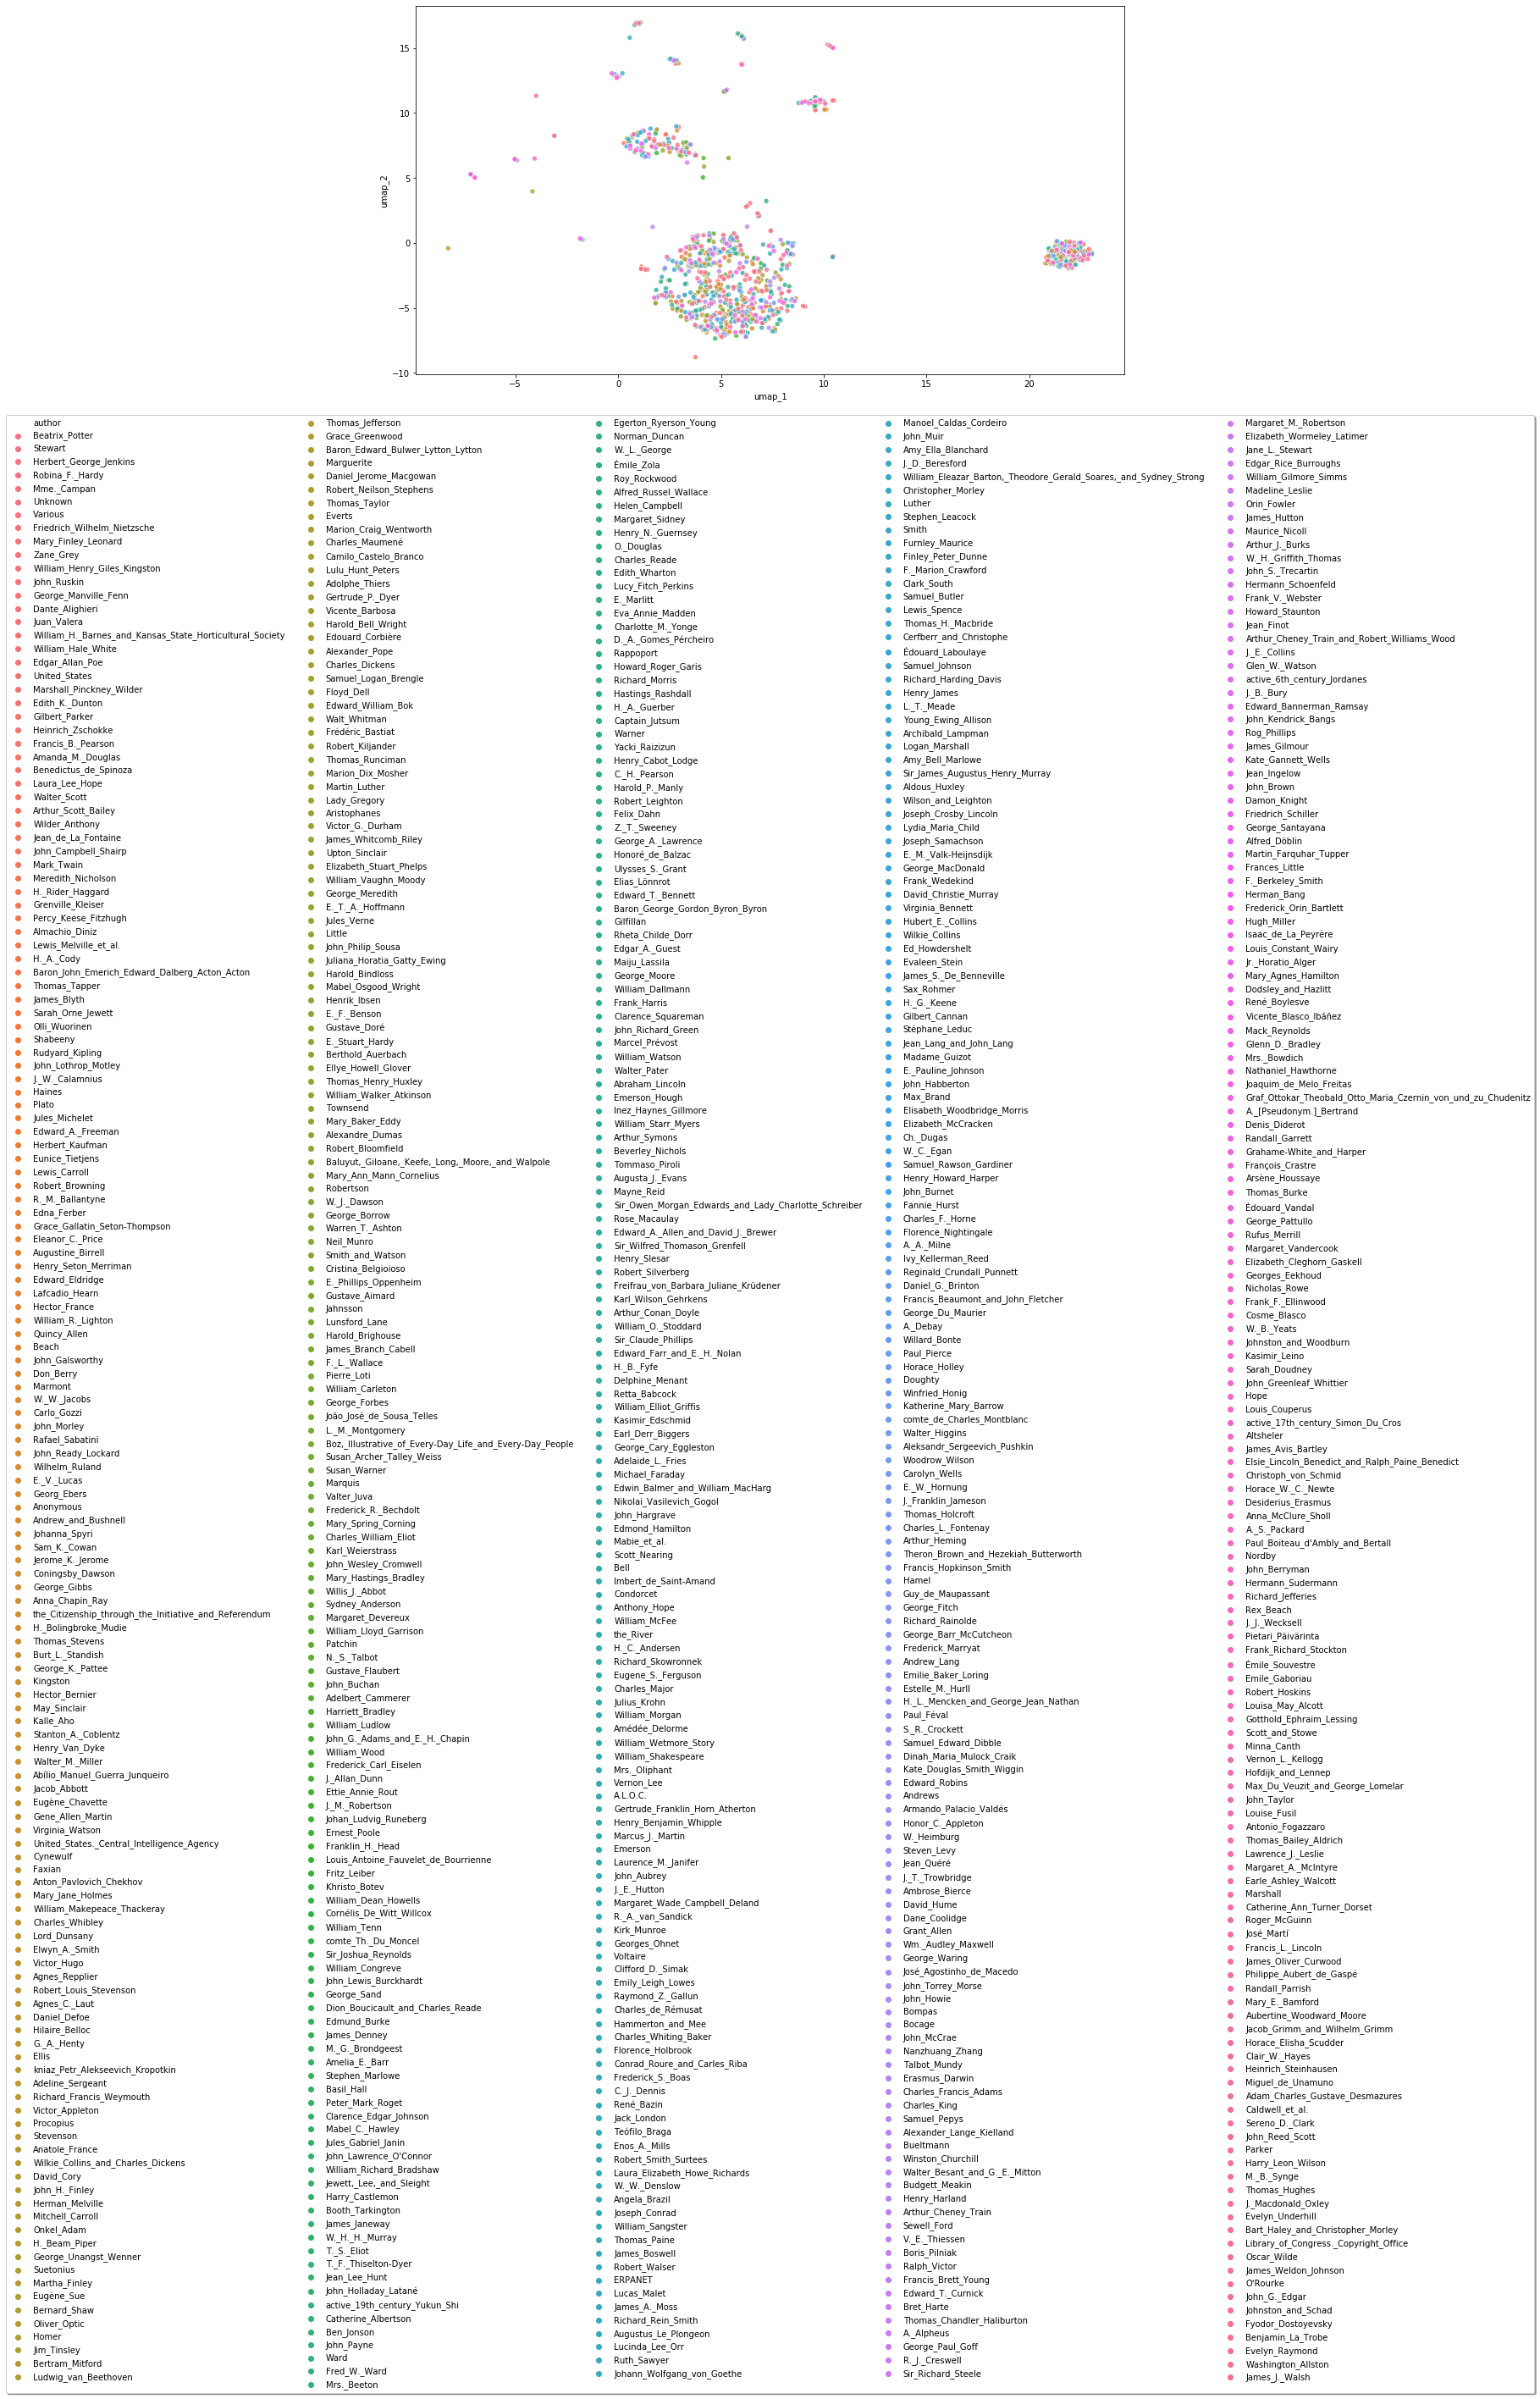

In [10]:
#fig, ax = plt.figure(figsize=(15,8))
v2_subset = v2_author_df[:1000]
fig = plt.figure(figsize=(15,8))
sns.scatterplot(x='umap_1', y='umap_2', hue='author', data=v2_subset, alpha=0.8, legend='brief')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
          fancybox=True, shadow=True, ncol=5)
plt.show()

### Plotly Interactive Scatter Plot

In [11]:
fig = px.scatter(v2_subset, x='umap_1', y='umap_2', color='author',
                 hover_data=['work'])
fig.show()

# Nearest Neighbors for Works

### Neighbors Search on 100-D Embeddings

In [ ]:
#np.save('10000_embeddings.npy', embeddings)

In [12]:
# build data frame with neighbor, author, work
neighbors = NearestNeighbors(n_neighbors=11, metric='cosine').fit(embeddings)
distances, inds = neighbors.kneighbors(embeddings)
full_neighbors = []
for idx in range(inds.shape[0]):
    sub_inds = inds[idx, :].tolist()
    df_author_and_works = v2_author_df.iloc[sub_inds, 1:3]
    authors = df_author_and_works['author'].values
    works = df_author_and_works['work'].values
    authors_and_works = np.column_stack((works, authors)).tolist()
    row_neighbors = []
    for row in authors_and_works:
        row_neighbors.extend(row)
      
    full_neighbors.append(row_neighbors)

random.shuffle(full_neighbors)
df_neighbors = pd.DataFrame(
    full_neighbors,
    columns=[
        'Query_Title', 'Query_Author',
        '1st_Match_Title', '1st_Match_Author',
        '2nd_Match_Title', '2nd_Match_Author',
        '3rd_Match_Title', '3rd_Match_Author',
        '4th_Match_Title', '4th_Match_Author',
        '5th_Match_Title', '5th_Match_Author',
        '6th_Match_Title', '6th_Match_Author',
        '7th_Match_Title', '7th_Match_Author',
        '8th_Match_Title', '8th_Match_Author',
        '9th_Match_Title', '9th_Match_Author',
        '10th_Match_Title', '10th_Match_Author',
    ]
)
df_neighbors.head(30)
#df_neighbors.sort_values(by=['Query_Title'], ascending=False).head(30)
#df_neighbors.to_csv('df_neighbors.csv', index=False)

Query_Title  \
0   Chums_in_Dixie;_or,_The_Strange_Cruise_of_a_Mo...   
1               The_Queen-like_Closet_or_Rich_Cabinet   
2                             The_Emperor_—_Volume_01   
3   The_Hollow_Needle;_Further_adventures_of_Arsen...   
4                    Récits_d'une_tante_(Vol._4_de_4)   
5                         A_Hero_and_Some_Other_Folks   
6   Julia_And_Her_Romeo:_A_Chronicle_Of_Castle_Bar...   
7                    Récits_d'une_tante_(Vol._4_de_4)   
8                    Récits_d'une_tante_(Vol._4_de_4)   
9       Lists_of_Stories_and_Programs_for_Story_Hours   
10                                 Los_pazos_de_Ulloa   
11  What_Became_of_Them?_and,_The_Conceited_Little...   
12                             The_Blood_of_the_Arena   
13                                    Castle_Rackrent   
14       Bunny_Brown_and_His_Sister_Sue_Keeping_Store   
15  Smarra_ou_les_démons_de_la_nuit:_Songes_romant...   
16                       Geronimo's_Story_of_His_Life   
17                   Récits_d'une_tante_(Vol._4_de_4)   
18                         Roman_History,_Books_I-III   
19                   Récits_d'une_tante_(Vol._4_de_4)   
20                   Récits_d'une_tante_(Vol._4_de_4)   
21                     The_Last_Cruise_of_the_Saginaw   
22                            Cricket_at_the_Seashore   
23                                 The_Ancient_Regime   
24             A_Voyage_to_Terra_Australis_—_Volume_2   
25                   Récits_d'une_tante_(Vol._4_de_4)   
26                                   Talks_on_Talking   
27                                  An_Unwilling_Maid   
28         König_Heinrich_der_vierte._Der_Erste_Theil   
29          Nick_Baba's_Last_Drink_and_Other_Sketches   

                     Query_Author  \
0            St._George_Rathborne   
1                  Hannah_Woolley   
2                     Georg_Ebers   
3                 Maurice_Leblanc   
4                          Boigne   
5               William_A._Quayle   
6           David_Christie_Murray   
7                          Boigne   
8                          Boigne   
9                     Effie_Power   
10  condesa_de_Emilia_Pardo_Bazán   
11                       G._Boare   
12          Vicente_Blasco_Ibáñez   
13                Maria_Edgeworth   
14                 Laura_Lee_Hope   
15                 Charles_Nodier   
16                       Geronimo   
17                         Boigne   
18                           Livy   
19                         Boigne   
20                         Boigne   
21                 George_H._Read   
22        Elizabeth_Weston_Timlow   
23                Hippolyte_Taine   
24               Matthew_Flinders   
25                         Boigne   
26              Grenville_Kleiser   
27           Jeanie_Gould_Lincoln   
28            William_Shakespeare   
29               George_Paul_Goff   

                                      1st_Match_Title  \
0   The_Boy_Scouts_in_the_Maine_Woods;_Or,_The_New...   
1   The_Lady's_Own_Cookery_Book,_and_New_Dinner-Ta...   
2                             The_Emperor_—_Volume_06   
3   The_Extraordinary_Adventures_of_Arsene_Lupin,_...   
4   The_Clockmaker_—_or,_the_Sayings_and_Doings_of...   
5   Library_of_the_World's_Best_Literature,_Ancien...   
6                                Wild_Youth,_Complete   
7   The_Clockmaker_—_or,_the_Sayings_and_Doings_of...   
8   The_Clockmaker_—_or,_the_Sayings_and_Doings_of...   
9     A_Guide_to_the_Best_Historical_Novels_and_Tales   
10                                         La_gaviota   
11                                     Story-Tell_Lib   
12                       The_Torrent_(Entre_Naranjos)   
13  The_Mirror_of_Literature,_Amusement,_and_Instr...   
14                        The_Story_of_a_Candy_Rabbit   
15                  Oeuvres_illustrées_de_George_Sand   
16  The_Adventures_of_Daniel_Boone:_the_Kentucky_r...   
17  The_Clockmaker_—_or,_the_Sayings_and_Doings_of...   
18                               Dio's_Rome

In [35]:
df_neighbors.loc[df_neighbors['Query_Author'] == 'John_Keats']
#df_neighbors.sort_values(by=['Query_Title'], ascending=False).head(30)

Query_Title Query_Author  \
8591                            Lamia   John_Keats   
21197                      Poems_1817   John_Keats   
21865  Keats:_Poems_Published_in_1820   John_Keats   

                                         1st_Match_Title  \
8591   The_Poetical_Works_of_Oliver_Wendell_Holmes_—_...   
21197                      A_Dome_of_Many-Coloured_Glass   
21865                                 Poems_of_Coleridge   

              1st_Match_Author       2nd_Match_Title  \
8591     Oliver_Wendell_Holmes  Songs,_Merry_and_Sad   
21197               Amy_Lowell  Miscellany_of_Poetry   
21865  Samuel_Taylor_Coleridge   The_Golden_Treasury   

                                2nd_Match_Author  \
8591                        John_Charles_McNeill   
21197                       William_Kean_Seymour   
21865  Francis_Turner_Palgrave_and_Alfred_Pearse   

                                         3rd_Match_Title  \
8591               The_Ride_to_the_Lady,_and_Other_Poems   
21197                                 The_Path_of_Dreams   
21865  The_Complete_Poetical_Works_of_Percy_Bysshe_Sh...   

           3rd_Match_Author                            4th_Match_Title  \
8591        Helen_Gray_Cone                               Provocations   
21197  Leigh_Gordon_Giltner  Lays_of_Ancient_Virginia,_and_Other_Poems   
21865               Shelley             The_Hundred_Best_English_Poems   

         4th_Match_Author  ...  \
8591       Sibyl_Bristowe  ...   
21197  James_Avis_Bartley  ...   
21865      Adam_L._Gowans  ...   

                                         6th_Match_Title 6th_Match_Author  \
8591                                    A_Day_with_Keats        May_Byron   
21197        L'Allegro,_Il_Penseroso,_Comus,_and_Lycidas      John_Milton   
21865  The_Death_of_Saul_and_other_Eisteddfod_Prize_P...          Unknown   

                     7th_Match_Title       7th_Match_Author  \
8591   The_Listeners_and_Other_Poems      Walter_De_la_Mare   
21197  Lundy's_Lane,_and_Other_Poems  Duncan_Campbell_Scott   
21865     Life_Immovable._First_Part         Kostes_Palamas   

                                   8th_Match_Title    8th_Match_Author  \
8591   How_the_Fairy_Violet_Lost_and_Won_Her_Wings  Marianne_L._B._Ker   
21197               The_Hundred_Best_English_Poems      Adam_L._Gowans   
21865                                 Poems_(1828)         Thomas_Gent   

                                         9th_Match_Title  \
8591   The_Sisters'_Tragedy,_with_Other_Poems,_Lyrica...   
21197  The_Poetical_Works_of_Oliver_Wendell_Holmes_—_...   
21865                                  A_Celtic_Psaltery   

             9th_Match_Author                              10th_Match_Title  \
8591                  Aldrich                    Daisy_Dare,_and_Baby_Power   
21197   Oliver_Wendell_Holmes                               In_Divers_Tones   
21865  Alfred_Perceval_Graves  The_Suppressed_Poems_of_Alfred_Lord_Tennyson   

                    10th_Match_Author  
8591             Rosa_Vertner_Jeffrey  
21197       Sir_Charles_G._D._Roberts  
21865  Baron_Alfred_Tennyson_Tennyson  

[3 rows x 22 columns]

### Neighbors Search on UMAP Embeddings, Euclidean Metric

In [ ]:
umap_embs = author_label_df[['umap_1', 'umap_2']].values.tolist()
neighbors = NearestNeighbors(n_neighbors=11, metric='euclidean').fit(umap_embs)
distances, inds = neighbors.kneighbors(umap_embs)
full_neighbors = []
for idx in range(inds.shape[0]):
    sub_inds = inds[idx, :].tolist()
    df_author_and_works = v2_author_df.iloc[sub_inds, 1:3]
    authors = df_author_and_works['author'].values
    works = df_author_and_works['work'].values
    authors_and_works = np.column_stack((works, authors)).tolist()
    row_neighbors = []
    for row in authors_and_works:
        row_neighbors.extend(row)
      
    full_neighbors.append(row_neighbors)

#random.shuffle(full_neighbors)
df_neighbors = pd.DataFrame(
    full_neighbors,
    columns=[
        'Query_Title', 'Query_Author',
        '1st_Match_Title', '1st_Match_Author',
        '2nd_Match_Title', '2nd_Match_Author',
        '3rd_Match_Title', '3rd_Match_Author',
        '4th_Match_Title', '4th_Match_Author',
        '5th_Match_Title', '5th_Match_Author',
        '6th_Match_Title', '6th_Match_Author',
        '7th_Match_Title', '7th_Match_Author',
        '8th_Match_Title', '8th_Match_Author',
        '9th_Match_Title', '9th_Match_Author',
        '10th_Match_Title', '10th_Match_Author',
    ]
)
#df_neighbors.head(20)
df_neighbors.sort_values(by=['Query_Title'], ascending=False).head(30)

### Neighbors Search on UMAP Embeddings, Cosine Metric

In [ ]:
umap_embs = author_label_df[['umap_1', 'umap_2']].values.tolist()
neighbors = NearestNeighbors(n_neighbors=11, metric='cosine').fit(umap_embs)
distances, inds = neighbors.kneighbors(umap_embs)
full_neighbors = []
for idx in range(inds.shape[0]):
    sub_inds = inds[idx, :].tolist()
    df_author_and_works = v2_author_df.iloc[sub_inds, 1:3]
    authors = df_author_and_works['author'].values
    works = df_author_and_works['work'].values
    authors_and_works = np.column_stack((works, authors)).tolist()
    row_neighbors = []
    for row in authors_and_works:
        row_neighbors.extend(row)
      
    full_neighbors.append(row_neighbors)

#random.shuffle(full_neighbors)
df_neighbors = pd.DataFrame(
    full_neighbors,
    columns=[
        'Query_Title', 'Query_Author',
        '1st_Match_Title', '1st_Match_Author',
        '2nd_Match_Title', '2nd_Match_Author',
        '3rd_Match_Title', '3rd_Match_Author',
        '4th_Match_Title', '4th_Match_Author',
        '5th_Match_Title', '5th_Match_Author',
        '6th_Match_Title', '6th_Match_Author',
        '7th_Match_Title', '7th_Match_Author',
        '8th_Match_Title', '8th_Match_Author',
        '9th_Match_Title', '9th_Match_Author',
        '10th_Match_Title', '10th_Match_Author',
    ]
)
#df_neighbors.head(30)
df_neighbors.sort_values(by=['Query_Title'], ascending=False).head(30)